# Msc Thesis - Adversarial FR Attacks

## Face Detection

Import the necessary libraries:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
from mtcnn.mtcnn import MTCNN
import cv2

### Rectangular Face extraction with OpenCV/FACENET (Other Alternatives include Facenet,etc)

The following function is used to crop a rectangular area of the face which will be used below for extracting face embeddings. With better face extraction mechanisms used, an increase in face embedding and classification accuracy is noticed. CHOOSE ONE OF THE TWO!

In [89]:
#NEEDS FIXING
# can detect multiple faces but for our tasks we assume just one face images only
def extract_faces_from_img(imagePath, required_size=(224, 224)):
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
                )
    roi_color=faces[0]
    print("Faces Found: {0}".format(len(faces)))
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi_color = image[y:y + h, x:x + w]
        print("[INFO] Object found. Saving locally.")
        cv2.imwrite(str(w) + str(h) + '_faces.jpg', roi_color)

    print ("Faces detected saved.")

    # resize pixels to the model size
    image = Image.fromarray(roi_color)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

In [108]:
# extract a single face from a given photograph
def extract_faces_from_img(filename, required_size=(224, 224)):
    # load image from file
    pixels = plt.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)

    print ("Faces detected saved.")

    return face_array

Let us first inspect a test image:

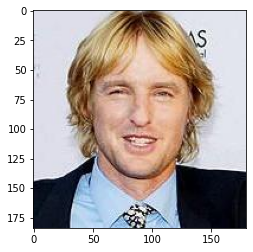

In [110]:
%matplotlib inline
test_img_path = '0002_02.jpg'

#read the image
test_img = Image.open(test_img_path)
#show image
plt.imshow(np.asarray(test_img))

Now, we can call the function above on the image to extract the face from the image. As you can see, preprocessing of the input image is handled by a keras_vggface library function.

Faces detected saved.


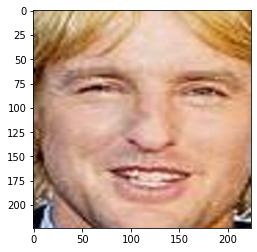

In [112]:
# load the photo and extract the face using the defined function for face extraction
pixels = extract_faces_from_img('0002_02.jpg')
#show extracted face rectangle
plt.imshow(np.asarray(pixels))
# convert one face into samples
pixels = pixels.astype('float32')
samples = np.expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)

## GENERATING FACE EMBEDDINGS WITH THE VGGFACE2 RESNET50 MODEL

In [66]:
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
	# extract faces
	faces = [extract_faces_from_img(f) for f in filenames]
	# convert into an array of samples
	samples = np.asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model
	model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
	# perform prediction
	yhat = model.predict(samples)
	return yhat

In [115]:
# extract faces and calculate face embeddings for a list of photo files
def get_single_embedding(filename):
    # extract faces
    faces = [extract_faces_from_img(filename) for f in list(filenames)]
    # convert into an array of samples
    samples = np.asarray(faces, 'float32')
    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)
    # create a vggface model
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    # perform prediction
    yhat = model.predict(samples)
    final_embedding = yhat[0]
    return yhat

In [45]:
# define filenames
filenames = ['test2/0016_01.jpg', 'test2/0040_01.jpg',
	'test2/0046_01.jpg', 'test2/0056_01.jpg']
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define id
test_id = embeddings[0]

Faces Found: 1
[INFO] Object found. Saving locally.
Faces detected saved.
Faces Found: 1
[INFO] Object found. Saving locally.
Faces detected saved.
Faces Found: 1
[INFO] Object found. Saving locally.
Faces detected saved.
Faces Found: 1
[INFO] Object found. Saving locally.
Faces detected saved.


In [46]:
# verify known photos of test subject from extracted face embeddings.
print('Positive Tests')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
# verify known photos of other people
print('Negative Tests')
is_match(embeddings[0], embeddings[3])

Positive Tests
>face is a Match (0.182 <= 0.500)
>face is NOT a Match (0.556 > 0.500)
Negative Tests
>face is NOT a Match (0.549 > 0.500)


## Classification Testing

FACE IDENTIFICATION FUNCTION

In [40]:
from scipy.spatial.distance import cosine

# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

SINGLE EXAMPLE OF MULTICLASS CLASSIFICATION

In [113]:
# create a vggface2 model which performs classification
multiclass_model = VGGFace(model='resnet50')
# perform prediction
yhat = multiclass_model.predict(samples)
# convert prediction into names
results = decode_predictions(yhat)

In [114]:
# display most likely results
for result in results[0]:
    percentage = result[1]*100
    iclass = result[0][3:-1:]
    print("{}: {:.3f}%".format(iclass,percentage))

Owen_Wilson: 99.689%
Rob_Smedley: 0.027%
Alfred_Dorfer: 0.019%
Richie_Sambora: 0.017%
David_Ginola: 0.016%


### ITERATIVE EXAMPLE

In [103]:
from os import listdir
from os.path import isfile, join
%matplotlib inline

test_dir_path = 'test2'
test_img_path = '0002_02.jpg'

test_img_files = [join(test_dir_path,f) for f in listdir(test_dir_path) if isfile(join(test_dir_path, f))]

#read the image
test_img = Image.open(test_img_path)

# get embedding of test image
test_img_embedding = get_single_embedding(test_img_path)
# get enbedding of comparable test images
test_dir_embeddings = get_embeddings(test_img_files)

TEST 0 :


<Figure size 432x288 with 0 Axes>

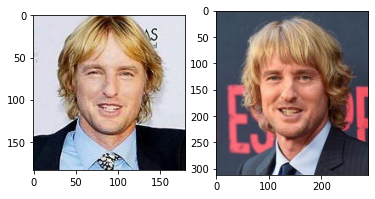

>face is a Match (0.182 <= 0.500)
TEST 1 :


<Figure size 432x288 with 0 Axes>

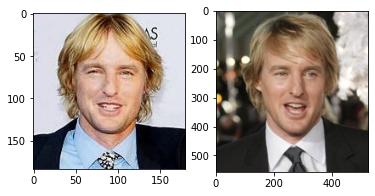

>face is a Match (0.181 <= 0.500)
TEST 2 :


<Figure size 432x288 with 0 Axes>

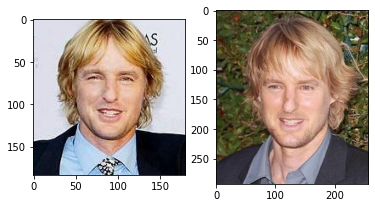

>face is a Match (0.157 <= 0.500)
TEST 3 :


<Figure size 432x288 with 0 Axes>

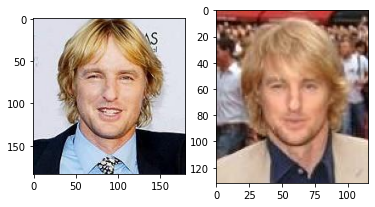

>face is a Match (0.186 <= 0.500)
TEST 4 :


<Figure size 432x288 with 0 Axes>

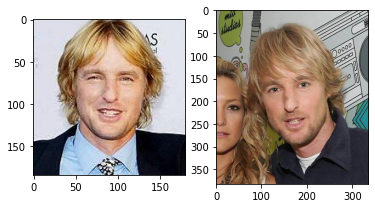

>face is a Match (0.254 <= 0.500)
TEST 5 :


<Figure size 432x288 with 0 Axes>

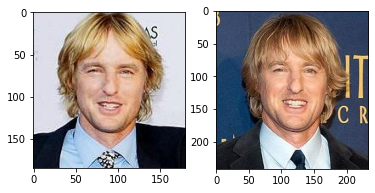

>face is a Match (0.158 <= 0.500)
TEST 6 :


<Figure size 432x288 with 0 Axes>

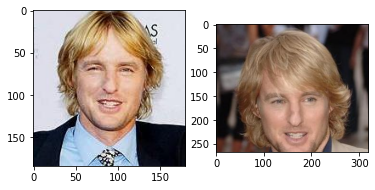

>face is a Match (0.162 <= 0.500)
TEST 7 :


<Figure size 432x288 with 0 Axes>

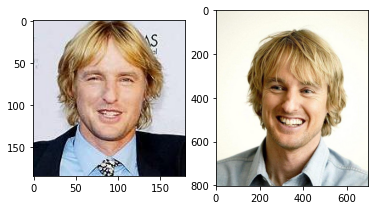

>face is a Match (0.200 <= 0.500)
TEST 8 :


<Figure size 432x288 with 0 Axes>

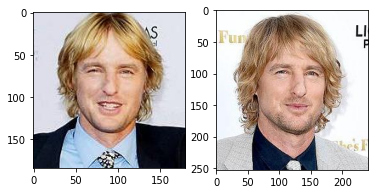

>face is a Match (0.187 <= 0.500)
TEST 9 :


<Figure size 432x288 with 0 Axes>

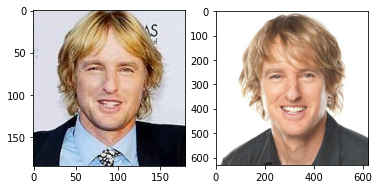

>face is a Match (0.157 <= 0.500)
TEST 10 :


<Figure size 432x288 with 0 Axes>

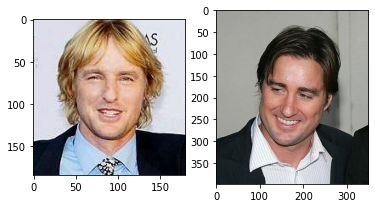

>face is NOT a Match (0.518 > 0.500)
TEST 11 :


<Figure size 432x288 with 0 Axes>

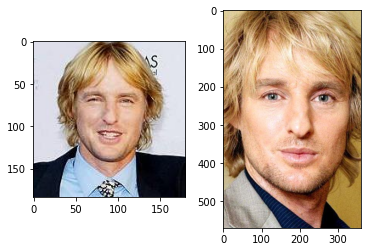

>face is a Match (0.208 <= 0.500)
TEST 12 :


<Figure size 432x288 with 0 Axes>

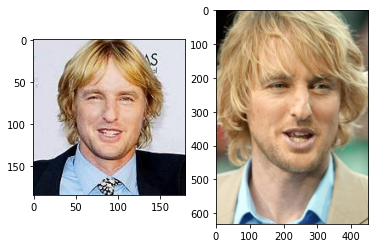

>face is a Match (0.288 <= 0.500)
TEST 13 :


<Figure size 432x288 with 0 Axes>

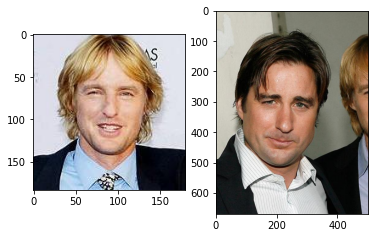

>face is NOT a Match (0.525 > 0.500)
TEST 14 :


<Figure size 432x288 with 0 Axes>

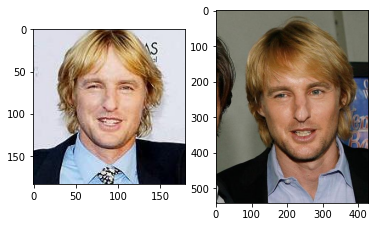

>face is a Match (0.171 <= 0.500)
TEST 15 :


<Figure size 432x288 with 0 Axes>

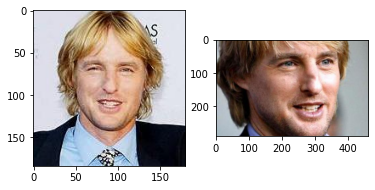

>face is NOT a Match (0.943 > 0.500)
TEST 16 :


<Figure size 432x288 with 0 Axes>

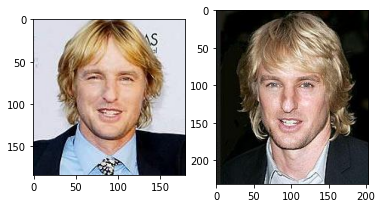

>face is a Match (0.199 <= 0.500)
TEST 17 :


<Figure size 432x288 with 0 Axes>

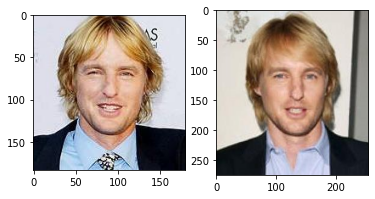

>face is a Match (0.179 <= 0.500)
TEST 18 :


<Figure size 432x288 with 0 Axes>

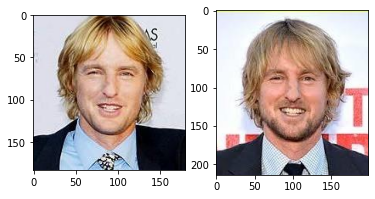

>face is a Match (0.183 <= 0.500)
TEST 19 :


<Figure size 432x288 with 0 Axes>

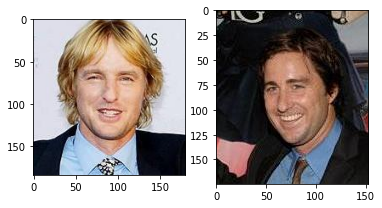

>face is NOT a Match (0.524 > 0.500)
TEST 20 :


<Figure size 432x288 with 0 Axes>

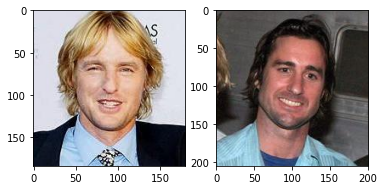

>face is NOT a Match (0.547 > 0.500)


In [107]:
# iterate over test folder
for idx, img_embedding in enumerate(test_dir_embeddings):
    print ('TEST', idx + ':')
    img_path = test_img_files[idx]
    #load next image in memory
    img_load = Image.open(img_path)
    # plot graph
    f = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(np.asarray(test_img))
    axarr[1].imshow(np.asarray(img_load))
    plt.show()
    is_match(test_img_embedding[0], img_embedding)
    print('\n')

## Attacks

## Classification Attack